In [1]:
"""
    File name: plot_tools.py
    Author: Amin Abyaneh
    Email: aminabyaneh@gmail.com
    Date created: 25/04/2021
    Python Version: 3.8
    Description: Extracting the execution data by plots.
"""

# ========================================================================
# Copyright 2021, The CFL Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# You may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ========================================================================

import os
from typing import Dict, List

import numpy as np
import seaborn
from matplotlib import pyplot as plt

from logging_settings import logger
from utils import retrieve_dsdi_stored_data, evaluate_inferred_matrix

import warnings
warnings.filterwarnings("ignore")

Detecting 1 CUDA device(s).


In [6]:
import seaborn as sns

sns.set_style("whitegrid", {
    "xtick.major.size": 0.1,
    "ytick.major.size": 0.1,
    'grid.linestyle': '--'
 })

sns.despine()

colors = ["blue", "green", "orange", "purple", "darkblue", "pink", "black", "brown", "cyan", "darkblue"]
rounds = np.arange(start=1, stop=10 + 1, step=1)


def plot_multiple_experiment_sets(experiments_directory: str, baseline_mats: List, graphs: List,
                                  experiment_set_id_dict: Dict[str, List[int]],
                                  number_of_rounds: int, labels_dict: Dict[str, List[str]],
                                  fig_name: str = 'compare_performance.png', metric='SHD',
                                  std_exageration: float = 0.3, single_legend: bool = False):
    """
    Plot the performance on the server side for more than one set of experiments. Best if you need to compare multiple
    different sets of experiments.

    Note: The matrices are parsed for each client individually, so later experiments on aggregation step could be
    performed easier. The aggregation step happens before plotting the error or performance.

    Args:
        experiments_directory (str): The directory where all the experiments are stored.
        baseline_mat (str): The ground truth for the structure learning algorithm.
        experiment_set_id_dict (Dict[str, str]): Indicating a list of experiment Ids corresponding to a experiment set
        to be plotted.

        number_of_rounds (int): For how many rounds do you want to plot each experiment. Should be less than the
        total number of rounds that you've experimented on.

        labels_dict (Dict[str, List[str]]): Label for each curve or experiment.
        fig_name (str): Name of the figure to be saved. Defaults to 'performance.png'. Change .png suffix to store in
        other formats.

        metric (str): The performance metric. Refer to utils.py. Defaults to 'ED' (Euclidean Distance).
    """

    n_row = 1
    n_col = 5
    n_plot = 3

    fig, axs = plt.subplots(n_row, n_col, figsize=(18, 3), dpi=100)
    fig.tight_layout(h_pad=1, w_pad=1.5)

    rounds = [round_id for round_id in range(1, 1 + number_of_rounds)]
    
    # Iterate over different sets
    for idx, experiment_name in enumerate(experiment_set_id_dict):
        logger.info(f'{idx}. Retrieving data for {experiment_name}.')
        experiment_directory = os.path.join(experiments_directory, experiment_name)
        
        # Subplot indexing
        row = 1
        col = idx // n_plot
        
        # Iterate over different ids, i.e., seeds
        metrics_list = list()
        for index, experiment_id in enumerate(experiment_set_id_dict[experiment_name]):
            metric_values: List[float] = list()

            for round_id in range(number_of_rounds):
                aggregated_adjacency_matrix: np.ndarray = None
                access_sum: int = 0

                for data in retrieve_dsdi_stored_data(experiment_directory, experiment_id, round_id):
                    if aggregated_adjacency_matrix is None:
                        aggregated_adjacency_matrix = data[0] * data[1]
                    else:
                        aggregated_adjacency_matrix += data[0] * data[1]
                    access_sum += data[0]

                inferred_matrix: np.ndarray = aggregated_adjacency_matrix / access_sum
                evaluation_dict = evaluate_inferred_matrix(baseline_mats[col], inferred_matrix)

                metric_values.append(evaluation_dict[metric])
            
            metrics_list.append(np.asarray(metric_values))
            
        metrics_avg = np.mean(np.asarray(metrics_list), axis=0)
        metrics_std = np.std(np.asarray(metrics_list), axis=0)
        
        axs[col].plot(rounds, metrics_avg, label=labels_dict[idx % n_plot], linestyle='solid', marker='o')
        axs[col].fill_between(rounds, metrics_avg - std_exageration * metrics_std,
                                  (metrics_avg + std_exageration * metrics_std),
                                   alpha=0.1)
            
        if single_legend:
            axs[n_col - 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            axs[col].legend(loc='best')

        axs[col].title.set_text(graphs[col])

        axs[0].set_ylabel(metric, fontsize=14)
        axs[col].set_xlabel('Round', fontsize=14)
        axs[col].set_xlim([0.5, 10.5])
            
        start, end = axs[col].get_ylim()
        axs[col].yaxis.set_ticks(np.arange(0, end, 5).astype(int))
        axs[col].xaxis.set_ticks(np.arange(1, 11, 1).astype(int))
    
    plt.show()

<Figure size 432x288 with 0 Axes>

In [17]:
# Define some ground truths for evaluation purposes
ground_truth_chain10 = np.asarray([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                   [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                   [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                   [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                   [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                   [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                   [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                                   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                                   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                                   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]])

ground_truth_full10 = np.asarray([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                 [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                 [1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                 [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                                 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0],
                                 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0],
                                 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]])

ground_truth_collider10 = np.asarray([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                      [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]])

ground_truth_jungle10 = np.asarray([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                    [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                    [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                    [0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                    [0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                    [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

ground_truth_bidiag10 = np.asarray([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                    [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                    [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                    [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                    [0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                                    [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                                    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0],
                                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
                                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]])

INFO - <ipython-input-6-2d53f962b9d4> - 54 - plot_multiple_experiment_sets - 2022-01-04 07:04:22,546 - 0. Retrieving data for balanced_full10_1client_1data.
WARNING - legend.py - 1228 - _parse_legend_args - 2022-01-04 07:04:22,603 - No handles with labels found to put in legend.
INFO - <ipython-input-6-2d53f962b9d4> - 54 - plot_multiple_experiment_sets - 2022-01-04 07:04:22,611 - 1. Retrieving data for balanced_full10_2client_2data.
WARNING - legend.py - 1228 - _parse_legend_args - 2022-01-04 07:04:22,678 - No handles with labels found to put in legend.
INFO - <ipython-input-6-2d53f962b9d4> - 54 - plot_multiple_experiment_sets - 2022-01-04 07:04:22,680 - 2. Retrieving data for balanced_full10_1client_2data.
WARNING - legend.py - 1228 - _parse_legend_args - 2022-01-04 07:04:22,735 - No handles with labels found to put in legend.
INFO - <ipython-input-6-2d53f962b9d4> - 54 - plot_multiple_experiment_sets - 2022-01-04 07:04:22,737 - 3. Retrieving data for balanced_chain10_1client_1data.
WA

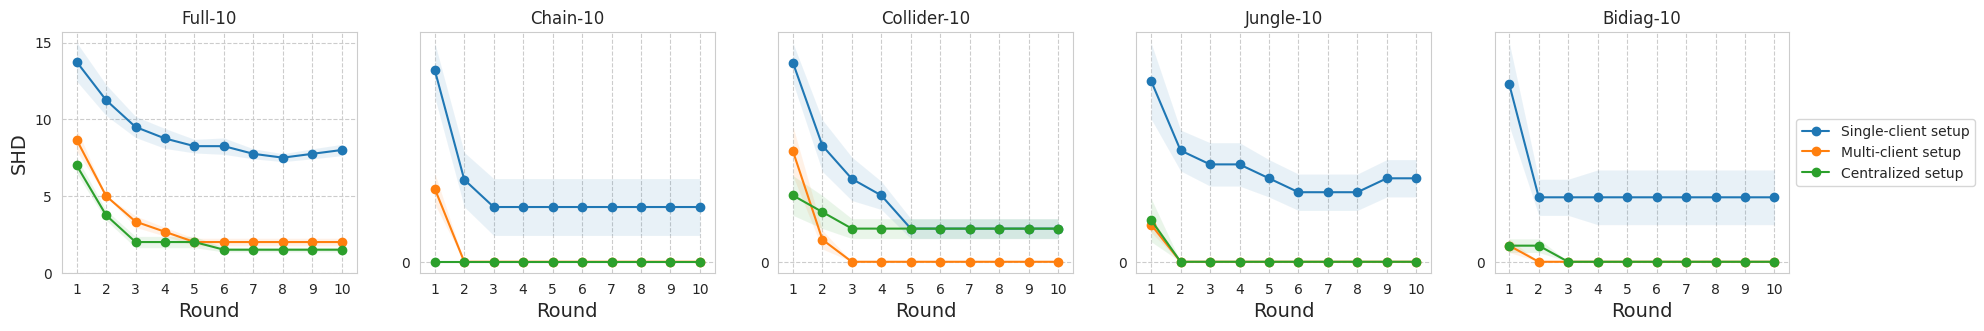

In [19]:
# Set experiment properties here
num_clients = [1, 2, 1]
data_coeff = [1, 2, 2]
num_rounds = 10
metric = 'SHD'

graphs = ['Full-10', 'Chain-10', 'Collider-10', 'Jungle-10', 'Bidiag-10']
baselines = [ground_truth_full10, ground_truth_chain10, ground_truth_collider10, ground_truth_jungle10, ground_truth_bidiag10]

# Plot the results based on the number of experiments
plot_multiple_experiment_sets(experiments_directory=f'../data/', baseline_mats=baselines, graphs=graphs,
                                experiment_set_id_dict={f'balanced_full10_1client_1data': [0, 1, 2, 3],
                                                        f'balanced_full10_2client_2data': [1, 2, 3],
                                                        f'balanced_full10_1client_2data': [0, 1, 2, 3],

                                                        f'balanced_chain10_1client_1data': [0, 1, 2, 3],
                                                        f'balanced_chain10_2client_2data': [1, 2, 3],
                                                        f'balanced_chain10_1client_2data': [0, 1, 2, 3],
                                                       
                                                        f'balanced_collider10_1client_1data': [0, 1, 2, 3],
                                                        f'balanced_collider10_2client_2data': [1, 2, 3],
                                                        f'balanced_collider10_1client_2data': [0, 1, 2, 3],
                                                       
                                                        f'balanced_jungle10_1client_1data': [0, 1, 2, 3],
                                                        f'balanced_jungle10_2client_2data': [1, 2, 3],
                                                        f'balanced_jungle10_1client_2data': [0, 1, 2, 3],
                                                       
                                                        f'balanced_bidiag10_1client_1data': [0, 1, 2],
                                                        f'balanced_bidiag10_2client_2data': [0, 1, 2],
                                                        f'balanced_bidiag10_1client_2data': [0, 1, 2],},
                                number_of_rounds=num_rounds,
                                labels_dict={0: 'Single-client setup', 
                                             1: 'Multi-client setup', 
                                             2: 'Centralized setup'},
                                
                                fig_name=f'structured_dsdi_{metric}.png', metric=metric, single_legend=True)
